
# Data Visualitation

Notebook ini berfungsi untuk melakukan proses visualisasi dan analisis eksploratori data pada dataset hasil preprocessing agar memberikan gambaran awal tentang struktur, kualitas, serta hubungan antar fitur. Adapun prosesnya meliputi hal berikut.

1. Membaca dataset hasil olahan `train_processed.csv`.
2. Membuat berbagai visualisasi dasar, yang meliputi proses distribusi nilai TARGET, tingkat missing value tertinggi, serta histogram fitur numerik untuk melihat sebaran data.
3. Melakukan analisis korelasi fitur terhadap TARGET, menampilkan hasil dalam bentuk boxplot dan heatmap korelasi antar fitur penting.
4. Menghitung dan memvisualisasikan Weight of Evidence (WOE) serta Information Value (IV) untuk fitur numerik dengan korelasi tertinggi terhadap TARGET, disertai penyimpanan tabel ringkasan IV.
5. Melakukan analisis segmentasi berdasarkan usia (AGE_BAND) dan masa kerja (EMP_BAND) untuk melihat rata-rata tingkat default (TARGET=1) per kelompok.
6. Menyimpan seluruh hasil visualisasi ke folder `../outputs/hasil_visualisasi/` agar dapat digunakan untuk pelaporan, analisis lanjutan, atau validasi model.


## 1) Setup dan Paths

In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Notebook path assumption:
ROOT = Path("..").resolve()
PROCESSED_DIR = ROOT / "data" / "dataset_hasil_data_processing"
OUT_IMG_DIR   = ROOT / "outputs" / "hasil_visualisasi"
OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = PROCESSED_DIR / "train_processed.csv"

print("ROOT:", ROOT)
print("TRAIN_PATH:", TRAIN_PATH)
print("OUT_IMG_DIR:", OUT_IMG_DIR)

# Load processed train data
df = pd.read_csv(TRAIN_PATH)
print("Train shape:", df.shape)
df.head(3)


ROOT: D:\Home Credit Virtual Internship\home_credit_scorecard_model
TRAIN_PATH: D:\Home Credit Virtual Internship\home_credit_scorecard_model\data\dataset_hasil_data_processing\train_processed.csv
OUT_IMG_DIR: D:\Home Credit Virtual Internship\home_credit_scorecard_model\outputs\hasil_visualisasi
Train shape: (307511, 442)


,TARGET,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,...,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_Unknown,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Unknown,EMERGENCYSTATE_MODE_Yes
0,1,-1.733423,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,0.435227,0.915580,1.306965,...,-0.136428,1.779079,-0.202211,-1.003528,1.021382,-0.069989,-0.062904,0.963763,-0.949252,-0.08734
1,0,-1.733413,-0.577538,0.426792,1.725450,0.592683,1.600873,-2.380655,-0.263424,-0.404071,...,-0.136428,1.779079,-0.202211,-1.003528,1.021382,-0.069989,-0.062904,0.963763,-0.949252,-0.08734
2,0,-1.733403,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,0.435227,0.915580,1.306965,...,-0.136428,-0.562089,-0.202211,0.996484,-0.979065,-0.069989,-0.062904,-1.037599,1.053461,-0.08734



## 2) Distribusi TARGET (Good vs Default)

**Tujuan**: mengecek keseimbangan kelas.
- **TARGET=0**: nasabah good (lunas tepat waktu)
- **TARGET=1**: nasabah default (gagal bayar)


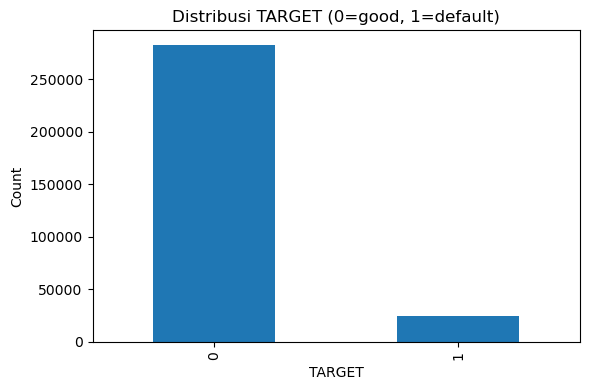

Saved: D:\Home Credit Virtual Internship\home_credit_scorecard_model\outputs\hasil_visualisasi\essential_01_distribusi_TARGET.png


In [17]:

if "TARGET" in df.columns:
    counts = df["TARGET"].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind="bar")
    plt.title("Distribusi TARGET (0=good, 1=default)")
    plt.xlabel("TARGET")
    plt.ylabel("Count")
    plt.tight_layout()
    out = OUT_IMG_DIR / "essential_01_distribusi_TARGET.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved:", out)
else:
    print("Kolom TARGET tidak ditemukan.")



## 3) Missing Values (Top 15 Kolom)

**Tujuan**: identifikasi kolom yang butuh perlakuan (imputasi/drop).


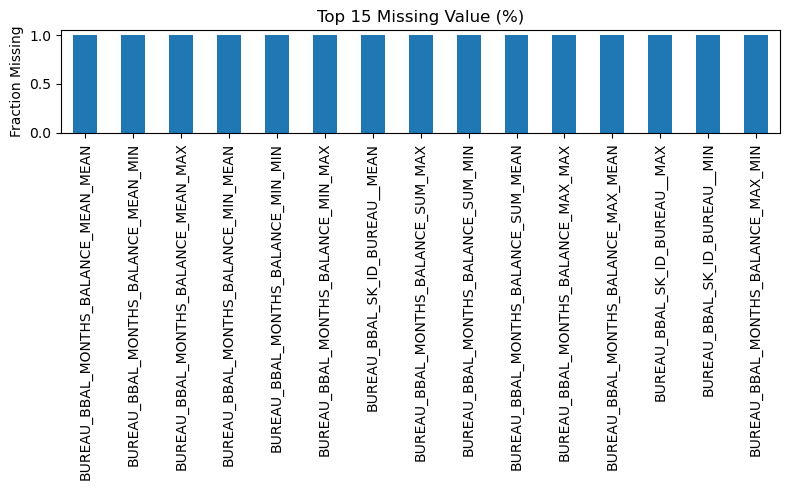

Saved: D:\Home Credit Virtual Internship\home_credit_scorecard_model\outputs\hasil_visualisasi\essential_02_missing_top15.png


In [18]:

missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
if not missing_pct.empty:
    top = missing_pct.head(15)
    plt.figure(figsize=(8,5))
    top.plot(kind="bar")
    plt.title("Top 15 Missing Value (%)")
    plt.ylabel("Fraction Missing")
    plt.tight_layout()
    out = OUT_IMG_DIR / "essential_02_missing_top15.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved:", out)
else:
    print("Tidak ada missing value yang signifikan.")


## 4) Pemilihan Fitur Kunci untuk Analisis

In [19]:

# Pilih beberapa fitur numerik penting bila ada
candidate_cols = [
    "AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY",
    "CREDIT_INCOME_RATIO","ANNUITY_INCOME_RATIO","CREDIT_ANNUITY_RATIO",
    "AGE_YEARS","YEARS_EMPLOYED",
    "EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
num_cols_available = [c for c in candidate_cols if c in df.columns]
# fallback: ambil 6 kolom numerik dengan varian terbesar (excl TARGET)
if len(num_cols_available) == 0:
    all_num = [c for c in df.select_dtypes(include=[np.number]).columns if c != "TARGET"]
    num_cols_available = list(pd.Series(all_num).sample(min(6, len(all_num))).values)

print("Fitur numerik untuk analisis:", num_cols_available)


Fitur numerik untuk analisis: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'AGE_YEARS', 'YEARS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']



## 5) Distribusi Fitur Numerik Kunci (Histogram)

**Tujuan**: cek skewness dan outlier pada fitur-fitur yang biasanya kuat di credit scoring (income, credit, annuity, rasio, usia, masa kerja).


In [ ]:

for c in num_cols_available:
    s = df[c].dropna()
    if s.empty:
        continue
    # clip untuk stabilitas visual
    q1,q99 = s.quantile(0.01), s.quantile(0.99)
    s = s.clip(q1, q99)
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=50)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    out = OUT_IMG_DIR / f"essential_03_hist_{c}.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved:", out)



## 6) Hubungan Antara Fitur dan Risiko (Boxplot vs TARGET, Top 4 Korelasi)

**Tujuan**: melihat perbedaan distribusi fitur antara good vs default.  


In [ ]:

if "TARGET" in df.columns:
    # pilih top 4 fitur numerik dengan korelasi absolut tertinggi thd TARGET
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != "TARGET"]
    if num_cols:
        corrs = df[num_cols + ["TARGET"]].corr()["TARGET"].abs().drop("TARGET", errors='ignore').sort_values(ascending=False)
        top4 = corrs.head(4).index.tolist()
        print("Top 4 corr features:", top4)
        for c in top4:
            data0 = df.loc[df["TARGET"]==0, c].dropna()
            data1 = df.loc[df["TARGET"]==1, c].dropna()
            s = df[c].dropna()
            q1,q99 = s.quantile(0.01), s.quantile(0.99)
            data0 = data0.clip(q1, q99)
            data1 = data1.clip(q1, q99)
            plt.figure(figsize=(6,4))
            plt.boxplot([data0.values, data1.values], labels=["TARGET=0","TARGET=1"], showfliers=False)
            plt.title(f"{c} vs TARGET")
            plt.ylabel(c)
            plt.tight_layout()
            out = OUT_IMG_DIR / f"essential_04_box_{c}_vs_TARGET.png"
            plt.savefig(out, dpi=150)
            plt.show()
            print("Saved:", out)
    else:
        print("Tidak ada fitur numerik untuk korelasi.")
else:
    print("TARGET tidak ditemukan — lewati analisis ini.")



## 7) Heatmap Korelasi (Fitur Kunci + TARGET)

**Tujuan**: cek multikolinearitas (penting untuk model Logistic Regression) dan identifikasi fitur yang redundan.

In [ ]:

selected = [c for c in (num_cols_available + ["TARGET"]) if c in df.columns]
if len(selected) >= 2:
    corr = df[selected].corr().values
    plt.figure(figsize=(1+0.6*len(selected), 1+0.6*len(selected)))
    im = plt.imshow(corr, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(selected)), selected, rotation=90)
    plt.yticks(range(len(selected)), selected)
    plt.title("Correlation Heatmap — Selected Features + TARGET")
    plt.tight_layout()
    out = OUT_IMG_DIR / "essential_05_heatmap_selected.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved:", out)
else:
    print("Fitur terpilih kurang dari 2 — lewati heatmap.")



## 8) WOE / IV
**Tujuan**: pilih fitur yang informatif dan stabil untuk scorecard atau logistic regression. 


In [ ]:

def _bin_numeric(series, n_bins=10):
    s = series.dropna()
    try:
        q = np.linspace(0, 1, n_bins+1)
        edges = s.quantile(q).values
        edges = np.unique(edges)
        if len(edges) <= 2:
            edges = np.unique(np.r_[s.min()-1e-9, s.median(), s.max()+1e-9])
        return pd.cut(series, bins=edges, include_lowest=True, duplicates='drop')
    except Exception:
        return pd.cut(series, bins=[s.min()-1e-9, s.max()+1e-9], include_lowest=True)

def woe_iv_table(df, feature, target_col="TARGET", n_bins=10):
    binned = _bin_numeric(df[feature], n_bins=n_bins)
    tab = df.groupby(binned, dropna=True)[target_col].agg(['count','sum'])
    tab = tab.rename(columns={'sum':'bad'})
    tab['good'] = tab['count'] - tab['bad']
    eps = 1e-9
    total_good = tab['good'].sum() + eps
    total_bad  = tab['bad'].sum()  + eps
    tab['dist_good'] = (tab['good'] + eps) / total_good
    tab['dist_bad']  = (tab['bad']  + eps) / total_bad
    tab['woe'] = np.log(tab['dist_good'] / tab['dist_bad'])
    tab['iv']  = (tab['dist_good'] - tab['dist_bad']) * tab['woe']
    tab = tab.reset_index().rename(columns={feature: 'bin'})
    tab['feature'] = feature
    return tab[['feature','bin','count','good','bad','dist_good','dist_bad','woe','iv']]

def plot_woe(table, title, out_path):
    plt.figure(figsize=(7,4))
    bins_str = table['bin'].astype(str).tolist()
    plt.plot(range(len(bins_str)), table['woe'].values, marker='o')
    plt.xticks(range(len(bins_str)), bins_str, rotation=90)
    plt.title(f"WOE per Bin — {title}")
    plt.xlabel("Bin")
    plt.ylabel("WOE")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)

if "TARGET" in df.columns:
    # pilih top 5 fitur numerik terkuat terhadap TARGET (berdasarkan |corr|)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != "TARGET"]
    if num_cols:
        corrs = df[num_cols + ["TARGET"]].corr()["TARGET"].abs().drop("TARGET", errors='ignore').sort_values(ascending=False)
        top5 = corrs.head(5).index.tolist()
        print("Top 5 numeric features by |corr|:", top5)

        iv_rows = []
        for feat in top5:
            tab = woe_iv_table(df[[feat, "TARGET"]].dropna(), feat, n_bins=10)
            iv_rows.append(tab)
            plot_woe(tab, feat, OUT_IMG_DIR / f"essential_06_woe_{feat}.png")

        iv_table = pd.concat(iv_rows, ignore_index=True)
        iv_summary = iv_table.groupby("feature", as_index=False)["iv"].sum().sort_values("iv", ascending=False)
        iv_table.to_csv(OUT_IMG_DIR / "essential_iv_table_detailed.csv", index=False)
        iv_summary.to_csv(OUT_IMG_DIR / "essential_iv_summary_by_feature.csv", index=False)
        print("Saved IV tables to folder.")
    else:
        print("Tidak ada fitur numerik untuk WOE/IV.")
else:
    print("TARGET tidak ada — WOE/IV dilewati.")



## 9) Default Rate per Segmen

**Tujuan**: mengetahui perbedaan risiko antar segmen untuk bahan kebijakan:
- **Principal**: plafon pinjaman per segmen (hindari over-leverage).
- **Maturity**: tenor lebih panjang untuk segmen dengan arus kas fluktuatif.
- **Repayment calendar**: tanggal jatuh tempo selaras pola gajian/arus kas segmen.


In [ ]:

seg_df = df.copy()

def make_age_band(s):
    import pandas as pd, numpy as np
    bins = [-np.inf, 25, 35, 45, 55, 65, np.inf]
    labels = ["<25","25-35","35-45","45-55","55-65",">65"]
    try:
        return pd.cut(s, bins=bins, labels=labels)
    except Exception:
        return pd.Series(["Unknown"]*len(s))

def make_emp_band(s):
    import pandas as pd, numpy as np
    bins = [-np.inf, 1, 3, 5, 10, 20, np.inf]
    labels = ["<=1y","1-3y","3-5y","5-10y","10-20y",">20y"]
    try:
        return pd.cut(s, bins=bins, labels=labels)
    except Exception:
        return pd.Series(["Unknown"]*len(s))

if "AGE_YEARS" in seg_df.columns:
    seg_df["AGE_BAND"] = make_age_band(seg_df["AGE_YEARS"])
else:
    seg_df["AGE_BAND"] = "Unknown"

if "YEARS_EMPLOYED" in seg_df.columns:
    seg_df["EMP_BAND"] = make_emp_band(seg_df["YEARS_EMPLOYED"])
else:
    seg_df["EMP_BAND"] = "Unknown"

for seg_col in ["AGE_BAND","EMP_BAND"]:
    if seg_col in seg_df.columns:
        grp = seg_df.groupby(seg_col)["TARGET"].mean().reindex(sorted(seg_df[seg_col].dropna().unique(), key=str))
        plt.figure(figsize=(7,4))
        grp.plot(kind="bar")
        plt.title(f"Default Rate per {seg_col}")
        plt.ylabel("Default Rate (mean TARGET)")
        plt.tight_layout()
        out = OUT_IMG_DIR / f"essential_07_default_rate_{seg_col}.png"
        plt.savefig(out, dpi=150)
        plt.show()
        print("Saved:", out)
